In [1]:
import VariationalBayes as vb
from VariationalBayes.SparseObjectives import SparseObjective, Objective
from VariationalBayes.Models.NormalMixture import normal_mixture as mix

import math

import autograd
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

#import copy
from copy import deepcopy
import scipy as sp
from scipy import optimize
from scipy import stats

In [2]:
# Number of data points:
num_obs = 1000

# Dimension of observations:
d_num = 2

# Number of clusters:
k_num = 2

mu_scale = 3
noise_scale = 0.5

true_pi = np.linspace(0.2, 0.8, k_num)
true_pi = true_pi / np.sum(true_pi)

mu_prior_mean = np.full(d_num, 0.)
mu_prior_cov = np.diag(np.full(d_num, mu_scale ** 2))
mu_prior_info = np.linalg.inv(mu_prior_cov)
#true_mu = np.random.multivariate_normal(mu_prior_mean, mu_prior_cov, k_num)
true_mu = np.array([ np.linspace(-2., 2., k_num), np.linspace(-2., 2., k_num)]).T

true_sigma = np.array([ np.diag(np.full(d_num, noise_scale ** 2)) + np.full((d_num, d_num), 0.1) \
                        for k in range(k_num) ])
true_info = np.array([ np.linalg.inv(true_sigma[k, :, :]) for k in range(k_num) ])

x, true_z, true_z_ind = mix.generate_data(num_obs, true_mu, true_sigma, true_pi)


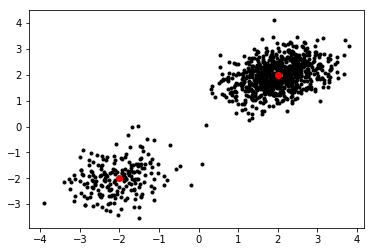

In [3]:
# Never a bad idea to visualize the dataz
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

In [4]:
global_params = vb.ModelParamsDict('global')
global_params.push_param(
    vb.PosDefMatrixParamVector(name='info', length=k_num, matrix_size=d_num))
global_params.push_param(
    vb.ArrayParam(name='mu', shape=(k_num, d_num)))
global_params.push_param(
    vb.SimplexParam(name='pi', shape=(1, k_num)))

local_params = vb.ModelParamsDict('local')
local_params.push_param(
    vb.SimplexParam(name='e_z', shape=(num_obs, k_num),
                    val=np.full(true_z.shape, 1. / k_num)))

params = vb.ModelParamsDict('mixture model')
params.push_param(global_params)
params.push_param(local_params)

true_init = False
if true_init:
    params['global']['info'].set(true_info)
    params['global']['mu'].set(true_mu)
    params['global']['pi'].set(true_pi)
else:
    params['global']['mu'].set(np.random.random(params['global']['mu'].shape()))
    
init_par_vec = params.get_free()
global_init_par_vec = params['global'].get_free()

print(params['global'])

global:
	info:
[[[ 1.  0.]
  [ 0.  1.]]

 [[ 1.  0.]
  [ 0.  1.]]]
	mu:
[[ 0.18369258  0.91764494]
 [ 0.41631932  0.75610328]]
	pi: [[ 0.5  0.5]]


In [5]:
prior_params = vb.ModelParamsDict()
prior_params.push_param(vb.VectorParam(name='mu_prior_mean', size=d_num, val=mu_prior_mean))
prior_params.push_param(vb.PosDefMatrixParam(name='mu_prior_info', size=d_num, val=mu_prior_info))
prior_params.push_param(vb.ScalarParam(name='alpha', val=2.0))
prior_params.push_param(vb.ScalarParam(name='dof', val=d_num + 2.0))

In [6]:
model = mix.Model(x, params, prior_params)
kl_obj = Objective(model.params['global'], model.kl)

In [7]:
# # Perform EM.

# model.params.set_free(init_par_vec)
# model.optimize_z()
# global_param_vec = model.params['global'].get_vector()
# kl = model.kl()

# for step in range(20):
#     global_free_par = model.params['global'].get_free()
#     local_free_par = model.params['local'].get_free()
    
#     # Different choices for the M step:
#     global_vb_opt = optimize.minimize(
#        lambda par: kl_obj.fun_free_split(par, local_free_par),
#        x0=global_free_par,
#        jac=lambda par: kl_obj.fun_free_global_grad(par, local_free_par),
#        hess=lambda par: kl_obj.fun_free_global_hessian(par, local_free_par),
#        method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-2})
#     model.params['global'].set_free(global_vb_opt.x)

#     # E-step:
#     model.optimize_z()

#     new_global_param_vec = model.params['global'].get_vector()
#     diff = np.max(np.abs(new_global_param_vec - global_param_vec))
#     global_param_vec = deepcopy(new_global_param_vec)
    
#     new_kl = model.kl()
#     kl_diff = new_kl - kl
#     kl = new_kl
#     print(' kl: {}\t\tkl_diff = {}\t\tdiff = {}'.format(kl, kl_diff, diff))
#     if diff < 1e-6:
#         break

# em_free_par = model.params.get_free()
# print('Done.')


In [21]:
def minimize_kl(kl_obj, init_x):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hess=kl_obj.fun_free_hessian,
        method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8})

    print('done')
    return vb_opt

vb_opt = minimize_kl(kl_obj, global_init_par_vec)
print(kl_obj.fun_free(vb_opt.x))

done
440.265934085


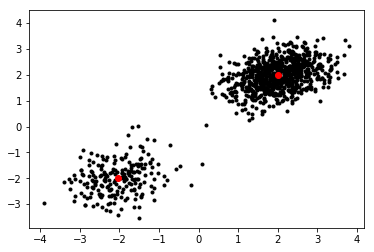

In [16]:
# Check that the solution looks sensible.
model.params['global'].set_free(vb_opt.x)
model.optimize_z()

mu_fit = model.params['global']['mu'].get()
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(mu_fit[k, 0], mu_fit[k, 1], 'ro')

In [10]:
moment_jac = model.get_moment_jacobian(vb_opt.x)
kl_hessian = kl_obj.fun_free_hessian(vb_opt.x)
sensitivity_operator = np.linalg.solve(kl_hessian, moment_jac.T)

In [11]:
def loglik_obs_set_z(global_free_par, model):
    model.params['global'].set_free(global_free_par)
    model.optimize_z()
    return model.loglik_obs()

eval_loglik_obs_set_z_jac = autograd.jacobian(loglik_obs_set_z)
weight_jac = eval_loglik_obs_set_z_jac(vb_opt.x, model)
data_sens = np.matmul(weight_jac, sensitivity_operator)
print(data_sens.shape)

(1000, 4)


In [32]:
# Check sensitivity upon refitting with a new model with non-unity weights.
model_perturbed = deepcopy(model)
kl_obj_perturbed = Objective(model_perturbed.params['global'], model_perturbed.kl)

In [38]:
# Jackknife weights.
rm_row = 5
perturbed_weights = np.full((num_obs, 1), 1.0)
perturbed_weights[rm_row] = 0.0

In [61]:
# Bootstrap weights.
perturbed_weights = \
    np.random.multinomial(num_obs, [1/float(num_obs)] * num_obs, size=1).T
print(perturbed_weights.shape)

(1000, 1)


In [62]:
model_perturbed.weights = perturbed_weights
vb_opt_reweight = minimize_kl(kl_obj_perturbed, vb_opt.x)
model_perturbed.params['global'].set_free(vb_opt_reweight.x)

print('Actual sensitivity:\t', 
      model_perturbed.get_interesting_moments(vb_opt_reweight.x) - \
      model.get_interesting_moments(vb_opt.x))
print('Predicted sensitivity:\t', np.matmul(perturbed_weights.T - 1.0, data_sens))

done
Actual sensitivity:	 [-0.01971352 -0.0280381  -0.03191383  0.04611709]
Predicted sensitivity:	 [[-0.01948746 -0.02773445 -0.03275913  0.04787253]]
